<a href="https://colab.research.google.com/github/MichaelSchmidt1729/EDA/blob/main/let_s_discover_more_about_the_olympic_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

We are using dataset available on Kaggle by the name "120 years of Olympic history: athletes and results" .This is a historical dataset on the modern Olympic Games, including all the Games from Athens 1896 to Rio 2016. The authors have scraped this data from www.sports-reference.com in May 2018. The R code they used to scrape and wrangle the data is on GitHub and I recommend to check their [kaggle kernel](https://www.kaggle.com/code/heesoo37/olympic-history-data-a-thorough-analysis/report).

The file athlete_events.csv contains 271116 rows and 15 columns. Each row corresponds to an individual athlete competing in an individual Olympic event (athlete-events).


# Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.graphics.gofplots as sm
from sklearn.preprocessing import PowerTransformer
plt.figure(figsize=(20, 10))
sns.set_style('darkgrid')

<Figure size 2000x1000 with 0 Axes>

# Load the data from your Google Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [14]:
data = pd.read_csv('/content/drive/MyDrive/datasets/athlete_events.csv', encoding='utf-8')
regions = pd.read_csv('/content/drive/MyDrive/datasets/noc_regions.csv', encoding='utf-8')

In [12]:
import os
def check_environment():
    if 'COLAB_GPU' in os.environ:
        from google.colab import drive
        drive.mount('/content/drive')
        data = pd.read_csv('/content/drive/MyDrive/datasets/athlete_events.csv', encoding='utf-8')
        regions = pd.read_csv('/content/drive/MyDrive/datasets/noc_regions.csv', encoding='utf-8')
    else:
        data = pd.read_csv('D:\\OneDrive\\Dokumente\\Pythonskripts\\Datasets\\athlete_events.csv', encoding='utf-8')
        regions = pd.read_csv('D:\\OneDrive\\Dokumente\\Pythonskripts\\Datasets\\noc_regions.csv', encoding='utf-8')

#überarbeiten

# Inspecting various attributes of imported data

Here we are basically just trying to get hang of our dataset before starting a more in depth analysis. If you can recall from the article, we are also computing the Descriptive statistics for the dataset.

In [15]:
print(data)

            ID                      Name Sex   Age  Height  Weight  \
0            1                 A Dijiang   M  24.0   180.0    80.0   
1            2                  A Lamusi   M  23.0   170.0    60.0   
2            3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN   
3            4      Edgar Lindenau Aabye   M  34.0     NaN     NaN   
4            5  Christine Jacoba Aaftink   F  21.0   185.0    82.0   
...        ...                       ...  ..   ...     ...     ...   
271111  135569                Andrzej ya   M  29.0   179.0    89.0   
271112  135570                  Piotr ya   M  27.0   176.0    59.0   
271113  135570                  Piotr ya   M  27.0   176.0    59.0   
271114  135571        Tomasz Ireneusz ya   M  30.0   185.0    96.0   
271115  135571        Tomasz Ireneusz ya   M  34.0   185.0    96.0   

                  Team  NOC        Games  Year  Season            City  \
0                China  CHN  1992 Summer  1992  Summer       Barcelona   
1          

In [16]:
#Check for Nan Values and deal with them
for col in data.columns:
    num_nan = data[col].isna().sum()
    pct_nan = (num_nan / len(data)) * 100
    print(f"Column {col} has {num_nan} NaN values ({pct_nan:.2f}%).")

Column ID has 0 NaN values (0.00%).
Column Name has 0 NaN values (0.00%).
Column Sex has 0 NaN values (0.00%).
Column Age has 9474 NaN values (3.49%).
Column Height has 60171 NaN values (22.19%).
Column Weight has 62875 NaN values (23.19%).
Column Team has 0 NaN values (0.00%).
Column NOC has 0 NaN values (0.00%).
Column Games has 0 NaN values (0.00%).
Column Year has 0 NaN values (0.00%).
Column Season has 0 NaN values (0.00%).
Column City has 0 NaN values (0.00%).
Column Sport has 0 NaN values (0.00%).
Column Event has 0 NaN values (0.00%).
Column Medal has 231333 NaN values (85.33%).


We found out that the data is missing height and weight for a good proportion of participants. We can use various techniques such as interpolation, forward or backward fill, use Machine Learning to predict the missing information, or set a fixed value to fill the missiing values, but for the sake of simplicity we will just drop these rows.Note that how we deal with Nan values impact the results, so generally we experiment till we get our desired results. For example you might see slight differences between some plots in notebook and in the article, this is because those plots are generated using data where Nan Values were not dropped.
Also in case of medals column, it is safe to assume that Nan specifies that no medal was won

In [17]:
data.dropna(subset=['Height','Weight','Age'], inplace=True)
# data['Height'].fillna(data['Height'].mean(), inplace=True)
# data['Weight'].fillna(data['Weight'].mean(), inplace=True)
# data['Age'].fillna(data['Age'].mean(), inplace=True)

In [18]:
data.skew()

TypeError: could not convert string to float: 'A Dijiang'

# Age is heavily right skewed -> some older athletes as outliers (see median below).
# Weight moderately left skewed -> outliers of high weight.

In [19]:
data.describe()

,ID,Age,Height,Weight,Year
count,206165.000000,206165.000000,206165.000000,206165.000000,206165.000000
mean,68616.017675,25.055509,175.371950,70.688337,1989.674678
std,38996.514355,5.483096,10.546088,14.340338,20.130865
min,1.000000,11.000000,127.000000,25.000000,1896.000000
25%,35194.000000,21.000000,168.000000,60.000000,1976.000000
50%,68629.000000,24.000000,175.000000,70.000000,1992.000000
75%,102313.000000,28.000000,183.000000,79.000000,2006.000000
max,135571.000000,71.000000,226.000000,214.000000,2016.000000


# WTF? Youngest athlete was 11. years old? min. weight is 25 kg? Edit: From North Korea, Gymnast.

# In 1896 there was a 10-year old Russian athlete. Dropped because: data.dropna(subset=['Height','Weight','Age'], inplace=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206165 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      206165 non-null  int64  
 1   Name    206165 non-null  object 
 2   Sex     206165 non-null  object 
 3   Age     206165 non-null  float64
 4   Height  206165 non-null  float64
 5   Weight  206165 non-null  float64
 6   Team    206165 non-null  object 
 7   NOC     206165 non-null  object 
 8   Games   206165 non-null  object 
 9   Year    206165 non-null  int64  
 10  Season  206165 non-null  object 
 11  City    206165 non-null  object 
 12  Sport   206165 non-null  object 
 13  Event   206165 non-null  object 
 14  Medal   30181 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 25.2+ MB


In [21]:
regions.head(5)

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [22]:
for col in regions.columns:
    print(f"Column {col} has {regions[col].isna().sum()} NaN values.")

Column NOC has 0 NaN values.
Column region has 3 NaN values.
Column notes has 209 NaN values.


# 4. Joining the dataframes

Using the 'Merge' function from Pandas, we have the ability to combine the two dataframes by using the 'NOC' column as the key

In [23]:
merged = pd.merge(data, regions, on='NOC', how='left')

Let's see the result:

In [ ]:
merged.head()

In [25]:
goldMedals = merged[(merged.Medal == 'Gold')]

In [ ]:
goldMedals.isnull().any()

In [ ]:
goldMedals.info()

Text(0.5, 1.0, 'Height vs Weight of Olympic Medalists')

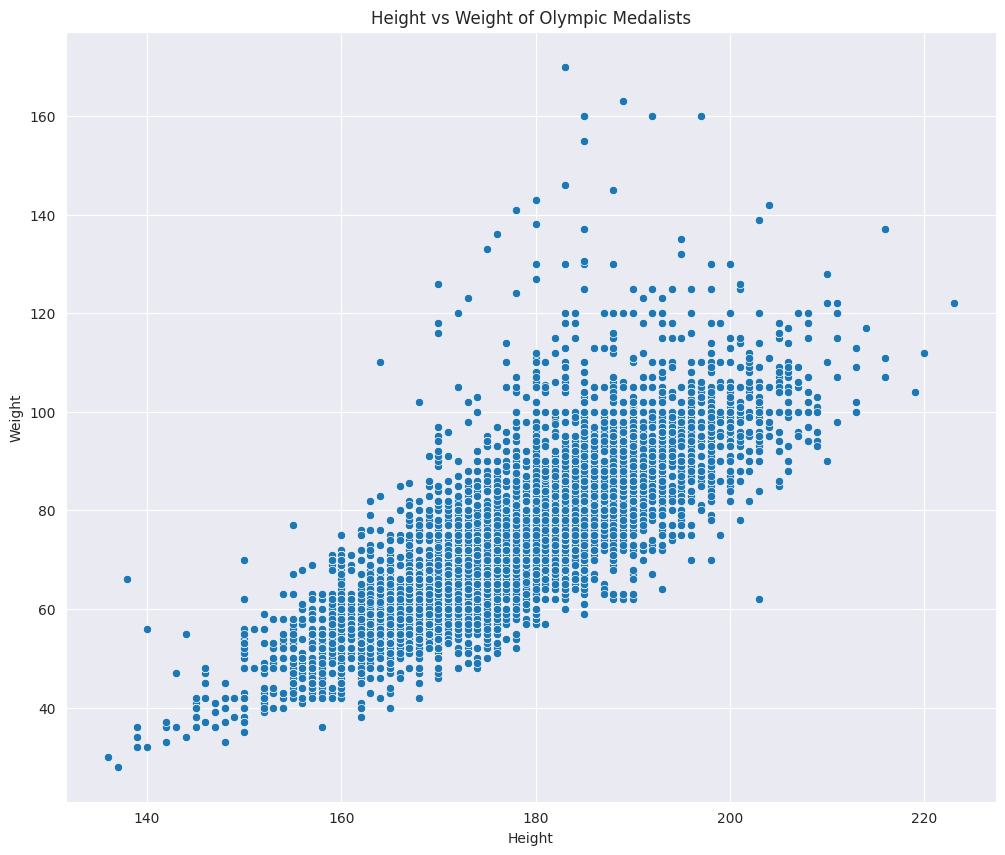

In [28]:
notNullMedals = goldMedals[(goldMedals['Height'].notnull()) & (goldMedals['Weight'].notnull())]
plt.figure(figsize=(12, 10))
ax = sns.scatterplot(x="Height", y="Weight", data=notNullMedals)
plt.title('Height vs Weight of Olympic Medalists')

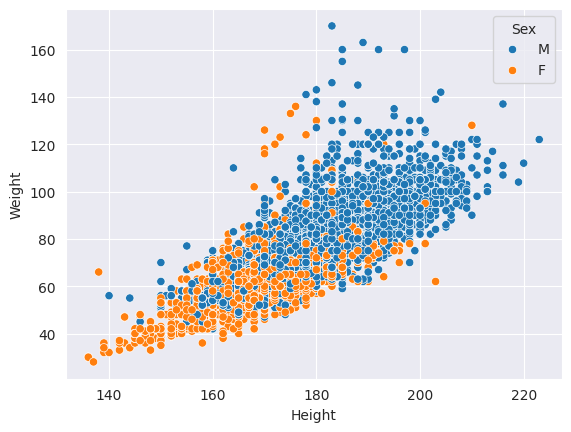

In [29]:
ax = sns.scatterplot(x="Height", y="Weight", hue="Sex", data=notNullMedals)

Text(0.5, 1.0, 'Gold Medals for Athletes Over 50')

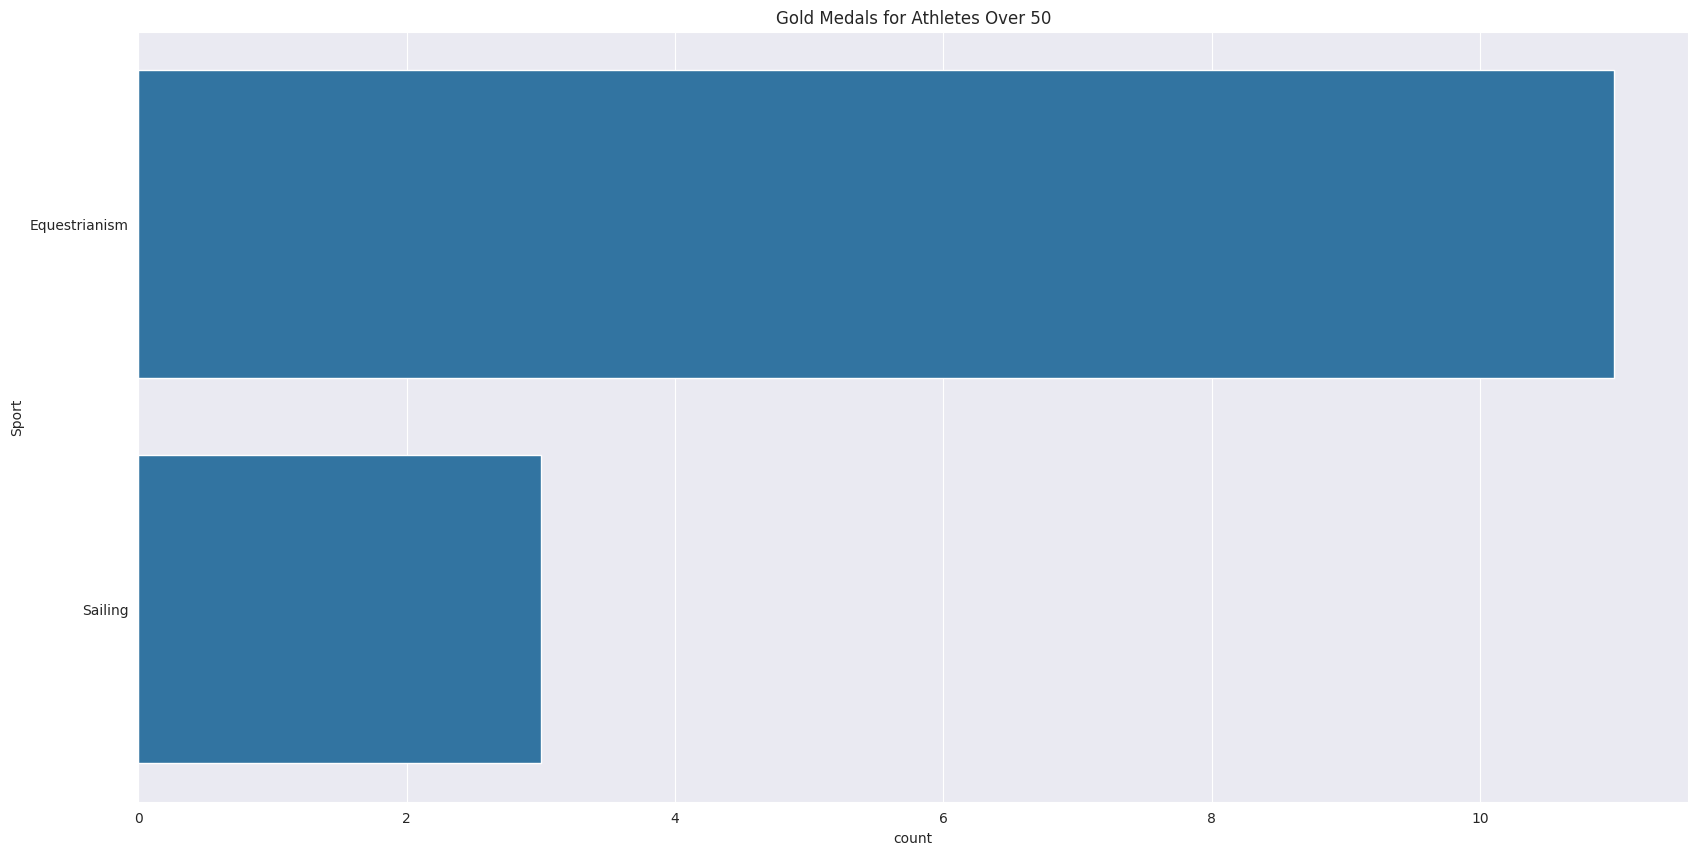

In [27]:
masterDisciplines = goldMedals['Sport'][goldMedals['Age'] > 50]
plt.figure(figsize=(20, 10))
plt.tight_layout()
sns.countplot(masterDisciplines)
plt.title('Gold Medals for Athletes Over 50')

# It seems that we have people with Age greater that 50 with a gold medal: Let’s know more about those people.

In [26]:
goldMedals['ID'][goldMedals['Age'] > 50].count()

14

# Additionally:

<Axes: >

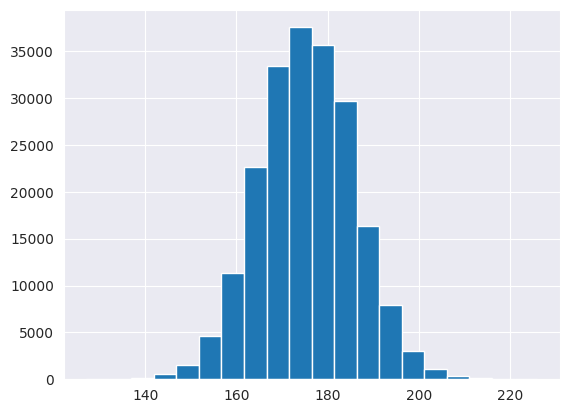

In [30]:
merged.Height.hist(bins=20)

## Normal Probability Plot

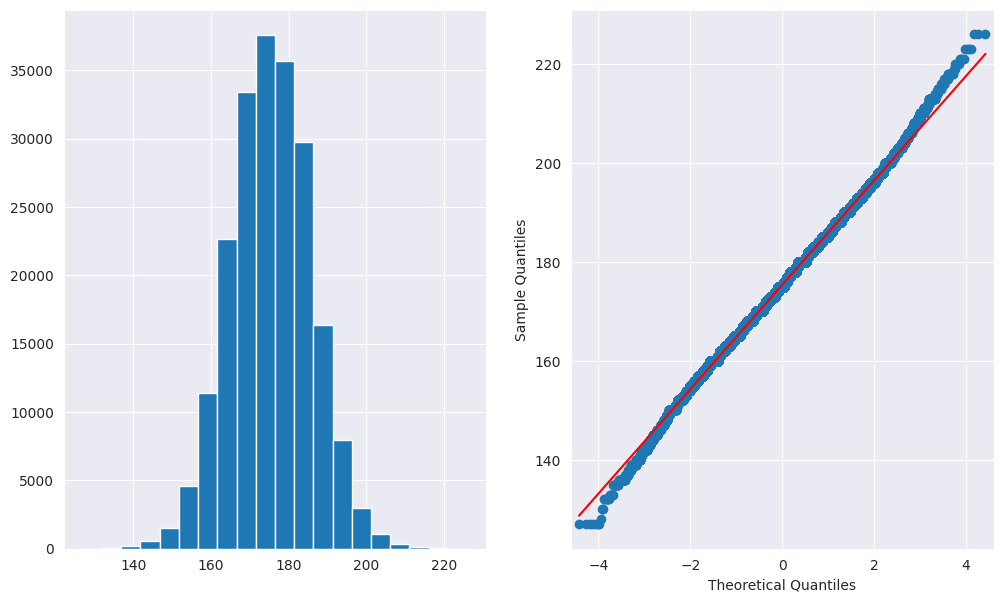

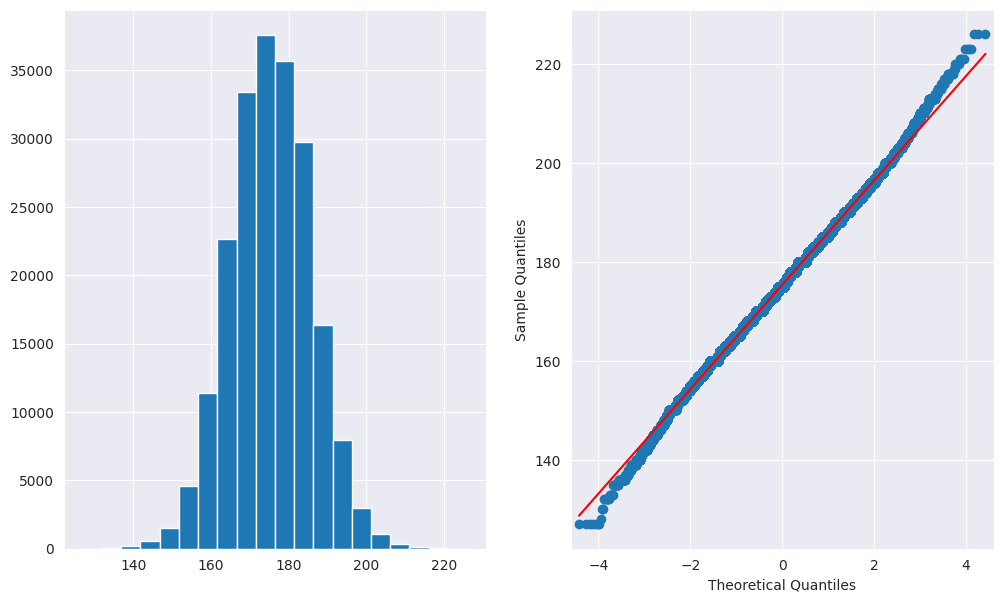

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
merged.Height.hist(bins=20,ax=ax[0])
sm.ProbPlot(merged.Height).qqplot(line='s', ax=ax[1])


## Kernel Distribution Estimation or KDE plot

<ipython-input-32-adaa94821aef>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=goldMedalsBasketball["Height"],shade=True,label="Basketball")
<ipython-input-32-adaa94821aef>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=goldMedalsSwimming["Height"],shade=True,label="Swimming")


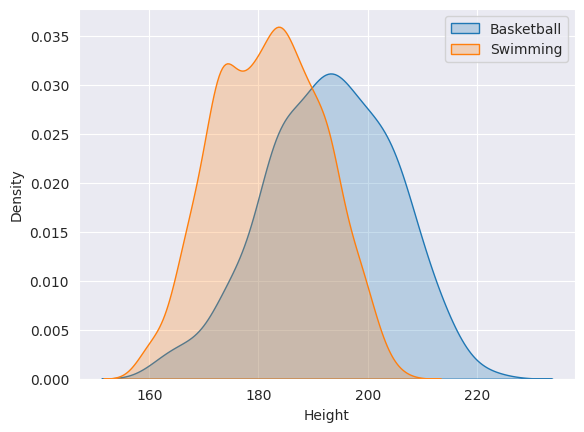

In [32]:
goldMedalsBasketball = merged[(merged.Medal == 'Gold')&(merged.Sport == 'Basketball')]
goldMedalsSwimming = merged[(merged.Medal == 'Gold')&(merged.Sport == 'Swimming')]
sns.kdeplot(data=goldMedalsBasketball["Height"],shade=True,label="Basketball")
sns.kdeplot(data=goldMedalsSwimming["Height"],shade=True,label="Swimming")

# Displaying the legend
plt.legend()

## Pie chart

In [34]:
goldMedals = merged[(merged.Medal == 'Gold')]
totalGoldMedals=goldMedals.region.value_counts().reset_index(name='Medal')

sorted_data = totalGoldMedals.sort_values('Medal', ascending=False).head(10)
values = sorted_data['Medal']
labels = sorted_data.index

# Assuming totalGoldMedals DataFrame is already defined and contains 'Medal' column
totalGoldMedals = totalGoldMedals.set_index('index')

# Sorting the DataFrame by the 'Medal' column in descending order
sorted_data = totalGoldMedals.sort_values('Medal', ascending=False)

# Extracting values and labels for the top 10
values_top10 = sorted_data['Medal'].head(10)
labels_top10 = sorted_data.index[:10]

# Extracting total medals for percentage calculation of all countries
total_medals_all = sorted_data['Medal'].sum()

# Custom autopct to show percentage of medals of top-10 countries and percentage of medals in regard to ALL countries
def custom_autopct(pct):
    total_top10 = sum(values_top10)
    val = int(round(pct*total_top10/100.0))
    percentage_of_all = (val / total_medals_all) * 100
    return f"{pct:.2f}%\n{val}\n{percentage_of_all:.2f}%"

# Creating the pie chart for top 10
plt.figure(figsize=(10, 8))
plt.pie(values_top10, labels=labels_top10, startangle=15, autopct=custom_autopct)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Top 10 Countries: Medals and Their Percentages')

# Adding text box
explanation_text = 'First row: % of medals of Top-10-Countries.\nSecond row: number of medals.\nThird row: % of medals in regard to ALL countries'
plt.gcf().text(0.5, 0.02, explanation_text, ha='center', va='bottom', fontsize=8, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

plt.show()

KeyError: "None of ['index'] are in the columns"

## Bar chart

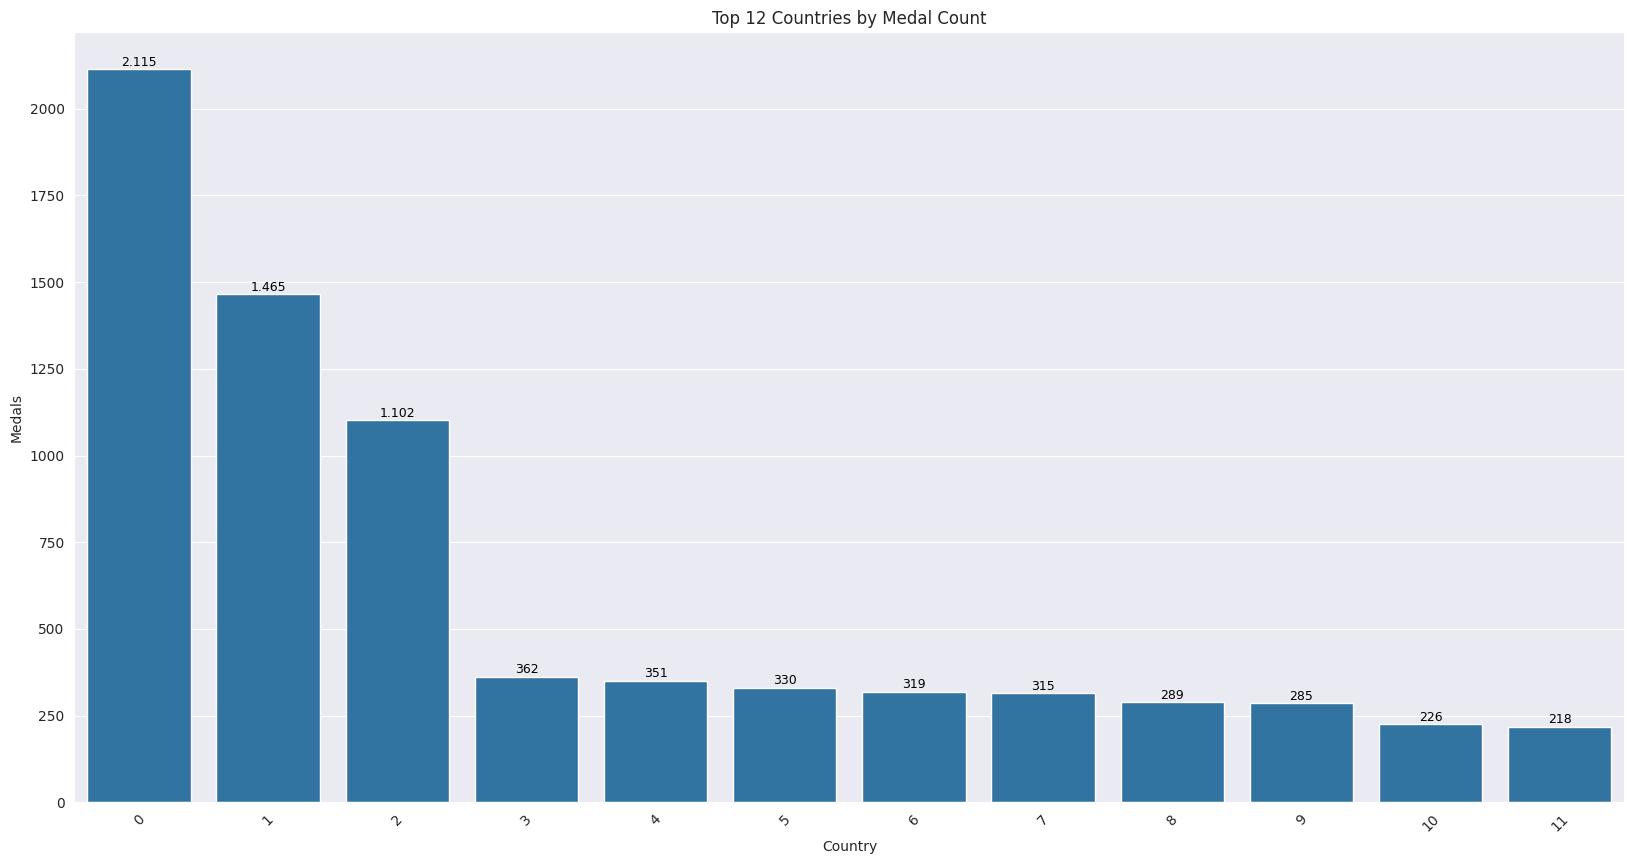

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming totalGoldMedals is your DataFrame and it has been prepared correctly

# If 'index' is not a column but the DataFrame's index, you need to reset the index first
totalGoldMedals = totalGoldMedals.reset_index()

# Plotting
plt.figure(figsize=(20, 10))
barplot = sns.barplot(x='index', y="Medal", data=totalGoldMedals.head(12)) # no of countries

# Annotating each bar with the number of medals
for p in barplot.patches:
    height = p.get_height()
    # Formatting the number with a dot as the thousands separator
    barplot.annotate(f'{height:,.0f}'.replace(',', '.'),
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='center',
                     fontsize=9, color='black',
                     xytext=(0, 5),
                     textcoords='offset points')

plt.xticks(rotation=45)
plt.title('Top 12 Countries by Medal Count')  # Updated title
plt.xlabel('Country')
plt.ylabel('Medals')
plt.show()


IntSlider(value=8, continuous_update=False, description='Number of Countries:', max=96, min=1)

Move the slider to change the number of countries.


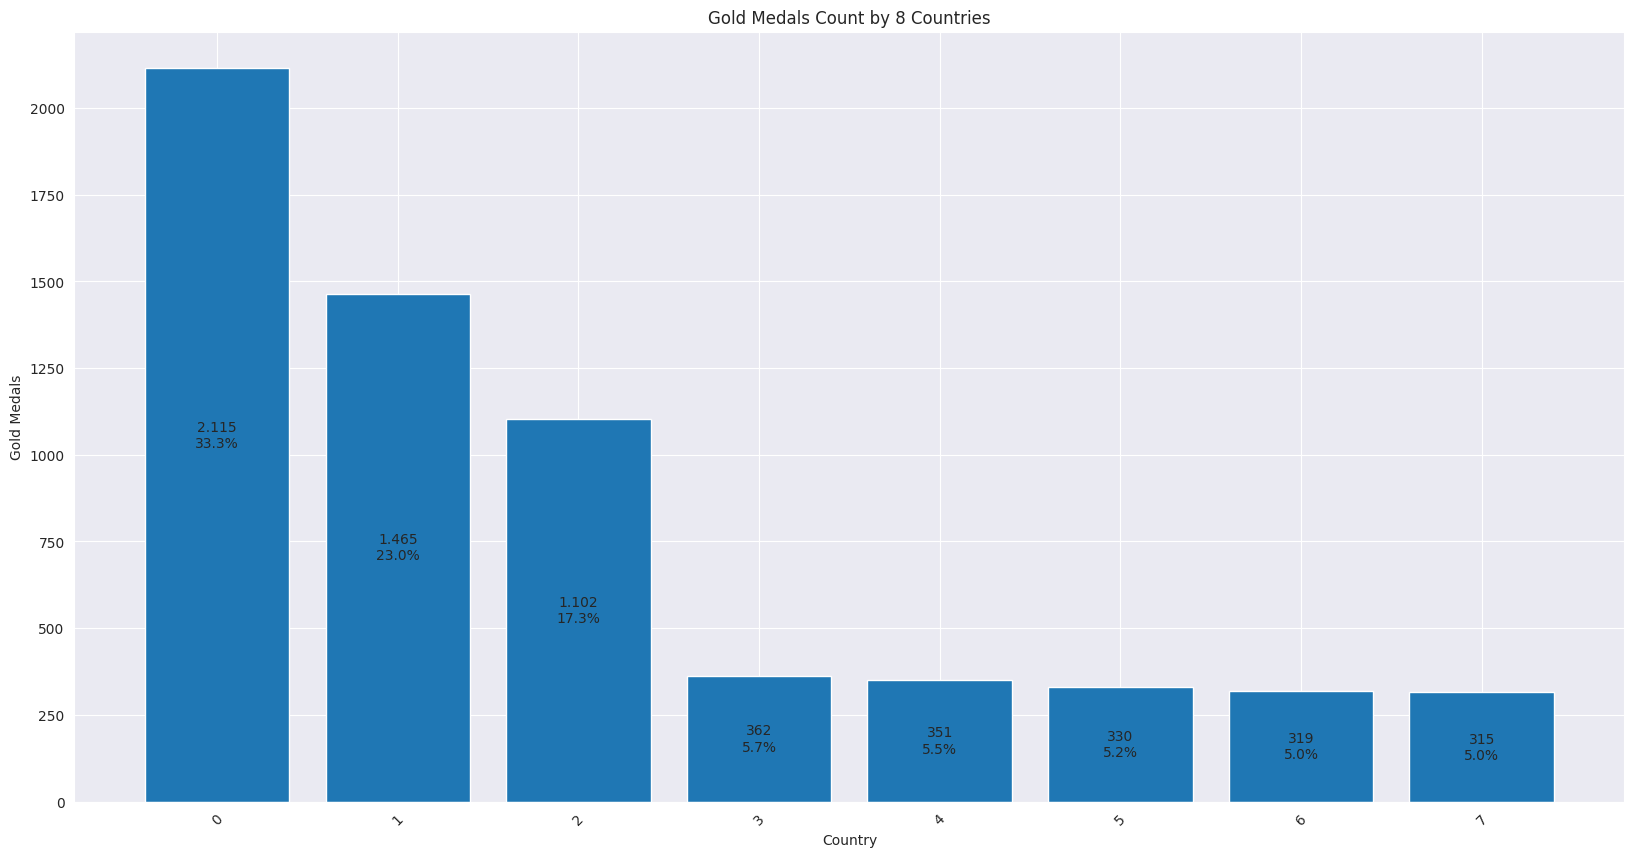

NameError: name 'plot_medals' is not defined

In [36]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Ensure totalGoldMedals has a 'Country' or similar column set correctly
# If resetting index moves country names into a column, ensure you're using the correct column name

def plot_goldmedals(n_countries):
    clear_output(wait=True)
    display(slider)  # Redisplay the slider
    print("Move the slider to change the number of countries.")  # Instruction text

    # Ensure the DataFrame is prepared with country names visible as a column, not as an index
    data = totalGoldMedals.reset_index().head(n_countries)
    plt.figure(figsize=(20, 10))
    bars = plt.bar(data['index'], data['Medal'])  # Make sure 'index' here matches the column with country names

    total_medals = data['Medal'].sum()

    for bar in bars:
        height = bar.get_height()
        percentage = f"{(height / total_medals) * 100:.1f}%"
        plt.text(bar.get_x() + bar.get_width() / 2.0, height / 2, f"{height:,}".replace(",", ".") + f"\n{percentage}", ha='center', va='center')

    plt.xlabel('Country')
    plt.ylabel('Gold Medals')
    plt.xticks(rotation=45)
    plt.title(f'Gold Medals Count by {n_countries} Countries')

    plt.show()

# Slider widget
slider = widgets.IntSlider(
    value=8,
    min=1,
    max=len(totalGoldMedals),  # assuming totalGoldMedals is a DataFrame
    step=1,
    description='Number of Countries:',
    continuous_update=False
)

def update_plot(change):
    plot_medals(change.new)

slider.observe(update_plot, names='value')

# Initial display
plot_goldmedals(slider.value)

## Stacked bar chart

In [ ]:
SilverMedals = merged[(merged.Medal == 'Silver')]
bronzeMedals = merged[(merged.Medal == 'Bronze')]
goldMedals = merged[(merged.Medal == 'Gold')]
s=SilverMedals.region.value_counts().reset_index(name='Silver')
b=bronzeMedals.region.value_counts().reset_index(name='Bronze')
g=goldMedals.region.value_counts().reset_index(name='Gold')
medal_data=pd.merge(g,pd.merge(s,b)).head(10)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# Assuming medal_data DataFrame is already prepared
# Example creation for context
# medal_data = pd.merge(g, pd.merge(s, b)).head(20)

def plot_medals(num_countries):
    clear_output(wait=True)
    display(slider)

    data = medal_data.head(num_countries)
    fig, ax = plt.subplots(figsize=(16, 8))
    data.plot(x='index', kind='bar', stacked=True, title=f'Distribution of Medals for Top {num_countries} Countries', ax=ax)

    total_medals = data[['Gold', 'Silver', 'Bronze']].sum().sum()

    for i, row in data.iterrows():
        cum_height = 0
        for medal_type in ['Gold', 'Silver', 'Bronze']:
            value = row[medal_type]
            if value > 0:
                # Formatting the number with a dot as the thousand separator
                formatted_value = f"{value:,}".replace(",", ".")
                percentage = (value / total_medals) * 100
                # Annotation for absolute value and percentage
                ax.text(i, cum_height + value / 2, f"{formatted_value}\n({percentage:.1f}%)", ha='center', va='center')
                cum_height += value

    plt.xticks(rotation=45)
    plt.ylabel('Number of Medals')
    plt.xlabel('Country')
    plt.show()

slider = widgets.IntSlider(
    value=20,  # Initial number of countries
    min=1,  # Minimum number of countries
    max=len(medal_data),  # Maximum number of countries
    step=1,  # Step size
    description='Number of Countries:',
    continuous_update=False
)

def on_slider_change(change):
    plot_medals(change.new)

slider.observe(on_slider_change, names='value')

display(slider)
plot_medals(slider.value)

## Line chart

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

womenInOlympics = merged[(merged.Sex == 'F') & (merged.Season == 'Summer')]
menInOlympics = merged[(merged.Sex == 'M') & (merged.Season == 'Summer')]


# Count of women athletes by year
womencount = womenInOlympics.groupby('Year')['Name'].count()

# Count of men athletes by year
mencount = menInOlympics.groupby('Year')['Name'].count()

# Plotting
plt.figure(figsize=(10, 6))

# Plot for women
sns.lineplot(x=womencount.index, y=womencount.values, label='Women', color='blue')

# Plot for men
sns.lineplot(x=mencount.index, y=mencount.values, label='Men', color='red')

plt.title('Number of Athletes per Edition of the Games')
plt.xlabel('Year')
plt.ylabel('Number of Athletes')
plt.legend()

plt.show()


## Run Sequence plot

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
merged['Height'].plot()  # Assuming 'merged' is a pandas DataFrame with a 'Height' column
plt.show()

## Area plot

In [ ]:
womenGold = merged[(merged.Sex == 'F') & (merged.Medal == 'Gold')& (merged.Season == 'Summer')]
menGold = merged[(merged.Sex == 'M') & (merged.Medal == 'Gold')& (merged.Season == 'Summer')]
womencount=womenGold.groupby(womenGold.Year).count()
mencount=menGold.groupby(menGold.Year).count()
x=pd.DataFrame(womencount.ID)
x=x.rename(columns={"ID": "Women"})
y=pd.DataFrame(mencount.ID)
y=y.rename(columns={"ID": "Men"})
NumberOfGold=x.join(y)


In [ ]:
NumberOfGold.plot.area(stacked=False,color=['pink','steelblue'],figsize=(18, 8))
plt.title('Medals won by woman in comparison with men per edition of the Games')

## Box plot

In [ ]:
# Set the figure size and DPI
plt.figure(figsize=(8, 6), dpi=80)

# Assuming 'merged' is your DataFrame containing 'Height', 'Weight', and 'Age' columns
merged.boxplot(column=['Height', 'Weight', 'Age'])

plt.show()

## Scatter plot

In [ ]:
sns.scatterplot(x='Height',y='Weight',hue="Sex",data=merged)

## Lag plot


In [ ]:
#shuffle dataset
merged=merged.sample(frac=1)

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)

# Create a lag plot for the 'Weight' column with lag=1
pd.plotting.lag_plot(merged['Weight'], lag=1)

plt.show()

## Pair plot

In [ ]:
sns.pairplot(merged[['Age','Height','Weight']])

## Heatmap

In [ ]:
sns.heatmap(merged[['Age','Height','Weight']].corr(), cmap="YlGnBu", annot=True)

## Which country has most and least number of Women gold medalist.

In [ ]:
womenGold = merged[(merged.Sex == 'F') & (merged.Medal == 'Gold')]
womenGold=womenGold.region.value_counts().reset_index(name='Medal')

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x='index',y="Medal",data=womenGold.head(20))
plt.title('Countries with most number of women gold medalsits ')

In [ ]:
# Example list of countries to highlight
highlight_countries = ['CountryName1', 'CountryName2']

def plot_goldmedals(n_countries):
    clear_output(wait=True)
    display(slider)  # Redisplay the slider
    print("Move the slider to change the number of countries.")  # Instruction text

    data = totalGoldMedals.reset_index().head(n_countries)
    plt.figure(figsize=(20, 10))

    # Check each country and decide the color
    colors = ['red' if country in highlight_countries else 'blue' for country in data['index']]

    bars = plt.bar(data['index'], data['Medal'], color=colors)  # Use colors list here

    total_medals = data['Medal'].sum()

    for bar in bars:
        height = bar.get_height()
        percentage = f"{(height / total_medals) * 100:.1f}%"
        plt.text(bar.get_x() + bar.get_width() / 2.0, height / 2, f"{height:,}".replace(",", ".") + f"\n{percentage}", ha='center', va='center')

    plt.xlabel('Country')
    plt.ylabel('Gold Medals')
    plt.xticks(rotation=45)
    plt.title(f'Gold Medals Count by {n_countries} Countries')

    plt.show()

# Adjusting slider appearance
slider_style = {'description_width': 'initial', 'handle_color': 'lightblue'}
slider = widgets.IntSlider(
    value=8,
    min=1,
    max=20,  # Adjust according to your DataFrame
    step=1,
    description='Number of Countries:',
    continuous_update=False,
    style=slider_style,
    layout=widgets.Layout(width='50%')  # Making the slider larger
)

def update_plot(change):
    plot_goldmedals(change.new)

slider.observe(update_plot, names='value')

# Initial display
plot_goldmedals(slider.value)

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x='index',y="Medal",data=womenGold.tail(20))
plt.title('Countries with least number of women gold medalsits ')